# Fast AI Model Prediction Done Over Labelled Data

## Importing and intalling Libraries Required

In [1]:
import pandas as pd #For loading data from csv
from sklearn.externals import joblib #For saving the model for future use
!pip3 install fastai
from fastai.text import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Reading Labelled data into Pandas DataFrame



In [4]:
labelled_data = pd.read_csv("labeled_data.csv")
labelled_data.head()

,text,label
0,The new rule is - \r\nif you are waiting for a...,4
1,"Flirted with giving this two stars, but that's...",3
2,I was staying at planet Hollywood across the s...,5
3,Food is good but prices are super expensive. ...,2
4,Worse company to deal with they do horrible wo...,1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Splitting the dataset into training and test dataset (75:25)

In [0]:
train = labelled_data.sample(frac=0.75, random_state=0)
test = labelled_data.drop(train.index)

### Load and analyse data for fast ai
 Fast ai expects the data as a data bunch so that it can use this for generating models. Here we will first create a data bunch with our train data set.

In [6]:
data = (TextList.from_df(train, cols='text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,"price to pay when the staff tells you at the track that you have to go to the kiddie karts ... they have their own stick and will measure too xxup before you get on . no reimbursement , no apologies ... xxmaj one measurement one place and another measurement at the track ? ? anyhow . a bit pricey but fun for something to do . xxmaj we are"
1,"veggie pad thai with peanut sauce ( extra 50 cents ) and he had the chicken curry with noodles . food was full of flavour and presented very nicely . i even took my leftovers the next day and it was still as good . xxbos xxmaj really enjoyed the food and friendly service . i am a huge xxmaj dim xxmaj sum fan , and would travel miles to"
2,"stumble out , my body shocked by the sudden , violent drop of my food - expectation high . i bite into my first dog and it just was n't even close to what i had hoped would be nitrate - xxunk heaven . xxmaj xxunk thinking about how i would be able to scrape the creamy cabbage from my hot dog as i head to the closest garbage bin"
3,walk in and am completely ignored by the lady in the front . i get that it is busy but it is everytime i order or go in . they should at least change the time i have to wait for the item so i am not sitting in the restaurant waiting . i still have yet to get my food ! or even been updated ! \r \n \r
4,", just before dinner rush at around 5:15 pm on a xxmaj monday . xxmaj no waiting at all , just able to go right in . \r \n \r \n xxmaj seats were comfortable , area was easy to maneuver around and find what i wanted . \r \n \r \n xxmaj seafood was fantastic , and mostly what i focused on for my meal . xxmaj"


### Fit the deep learning model with domain specific data
First we will fit our model with train data without target values so that our model knows better about our data.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,4.031153,3.917310,0.274855,10:05
1,4.003060,3.896548,0.276950,10:06
2,3.866252,3.843400,0.282339,10:06
3,3.725043,3.796235,0.286798,10:06
4,3.608708,3.786270,0.288169,10:07


epoch,train_loss,valid_loss,accuracy,time
0,3.504121,3.687009,0.299884,11:52
1,3.463949,3.618218,0.308244,11:54
2,3.309155,3.587775,0.313342,11:54
3,3.124125,3.593755,0.315194,11:54
4,2.995614,3.616450,0.313969,11:53


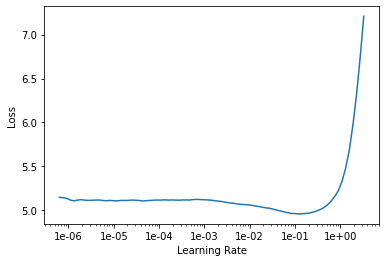

In [8]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
learn.recorder.plot()

# Fit the model based on selected learning rate
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
# Tune a little more
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

# Save the encoder for use in classification
learn.save_encoder('fine_tuned_enc')

### Re-fit model with classification label
Here we will re-fit our model with our target values and tuned our model for better accuracy result.

In [9]:
test_datalist = TextList.from_df(test, cols='text', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'label')
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
"xxbos i am not a xxunk reviewer , in fact , i rarely do so . xxmaj however , the xxup second of two bad experiences really motivated me to do so due to the sheer arrogance of nonetheless - the owner ! xxmaj yes - the owner ! ! \r \n \r \n xxmaj first xxmaj negative xxmaj experience : xxmaj went on a xxmaj sunday with my",1
"xxbos xxup update : xxmaj the only thing that the owner has right on his comment is that i assured him i 'd do whatever i could to let xxmaj pittsburgh know what type of business he is running . xxmaj he specifically said that "" i 'm not the first & certainly not the last "" & that he 'd love the "" free publicity "" so i made",1
"xxbos xxmaj this was a super tough pill to swallow , i fully intended to dig my heels in here and let my 2 - 3 star reviews stand following a former uber negative customer experience 4 years ago , but in the world of second chances xxmaj islington xxmaj chrysler xxup fiat rose to the occasion this week and really redeemed themselves . \r \n \r \n i",4
"xxbos xxmaj the xxmaj palisades was my first apartment moving out of my parents house . xxmaj my roommate and i both worked right across the street at a restaurant near the mall , so the 2 minute drive , literally , was the only good thing about this place . xxmaj that being said : \r \n \r \n xxmaj our unit , that was supposedly almost 1,000",1
"xxbos i booked this xxmaj hotel through xxmaj orbitz due to needing a last minute room for a business weekend . i wanted to save but also wanted something comfortable and safe . xxmaj when i checked in , i was told that i would receive a non - smoking room . i had three suitcases from just flying in from xxup las and i had to drag my bags",1


Now let’s predict the target values and compare with original target values.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,1.092019,0.961733,0.568533,05:30
1,1.093169,0.950080,0.582267,06:27
2,1.044611,0.921719,0.593467,05:40
3,1.031445,0.901005,0.604000,06:32
4,1.035003,0.895647,0.607067,05:27


epoch,train_loss,valid_loss,accuracy,time
0,1.027489,0.894694,0.607733,06:58
1,0.949160,0.861698,0.628000,07:20
2,0.883429,0.846856,0.634800,07:13
3,0.823417,0.812630,0.656267,06:06
4,0.773115,0.833887,0.651333,06:30


epoch,train_loss,valid_loss,accuracy,time
0,0.760222,0.845637,0.640000,10:17
1,0.777522,0.813919,0.649600,09:14
2,0.679122,0.839180,0.656000,10:35
3,0.545775,0.876894,0.644133,11:52
4,0.464082,0.918403,0.642533,11:39


text,target,prediction
"xxbos xxmaj okay , stayed here xxmaj mon . , xxmaj oct. 21st - xxmaj fri . , xxmaj oct. 25th . xxup omg ! xxmaj what a nightmare ! i will never stay here until renovations are done . xxmaj there is two major pros ... price ( it 's so cheap ! ) and location , location , location . xxmaj seriously , you 're dab smack in",1,2
"xxbos i was n't expecting much when i flew xxmaj allegiant xxmaj air , but they failed to live up to even those low expectations . xxmaj considering the dirt - cheap xxunk , i was n't exactly expecting a first class experience . i did , however , expect a less than miserable experience . xxmaj with little exception , xxmaj allegiant was miserable from beginning to end .",1,1
"xxbos xxup cj , a manager , had contacted me and asked me to call him about my experiences . xxmaj we chatted and i said i would give them another try . \r \n \r \n xxmaj amy recognized me ( good or bad , i was impressed ) and made no bones about apologizing for that first night and expressing her hope that this time would be",2,3
"xxbos xxmaj in our continuing quest to identify cool , locally owned places to eat and / or drink , xxmaj caroline and i xxunk xxmaj vintage 95 last night . \r \n \r \n xxmaj before i go further , understand that whenever i go out for eats or drinks , i have in mind a xxmaj platonic xxmaj ideal of the xxmaj bar / xxmaj pub /",4,4
"xxbos xxmaj after seeing these negative reviews splurged all over this page like a raw sewage leak , i figured we 'd pour a little more gas on the fire . i mean it really is just one after another and i can attest every nightmare on this page is the real deal xxmaj xxunk ladies and gents . xxmaj let me throw a few numbers out here : \r",1,5


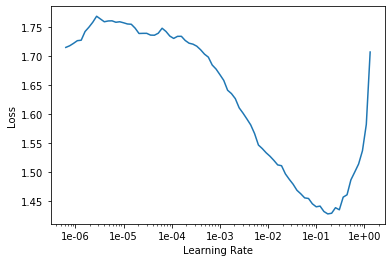

In [10]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# load the encoder saved  
learn_classifier.load_encoder('fine_tuned_enc')

learn_classifier.freeze()

# select the appropriate learning rate
learn_classifier.lr_find()

# we typically find the point where the slope is steepest
learn_classifier.recorder.plot()

# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(5, 2e-2, moms=(0.8,0.7))

# Tune a little more
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

# Tune a little more
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

learn_classifier.show_results()

Here we can see that in the final round it is showing accuracy around 65%

### Saving the model using joblib

In [0]:
filename = 'fastAIModel.sav'
joblib.dump(learn_classifier, filename)


['fastAIModel.sav']

### Pseudo labelling first 50K rows of unlabelled data
loading the unlabelled data

In [0]:
unlabelled_data = pd.read_csv("unlabeled_data.csv")
unlabelled_data50 = unlabelled_data[:50000]

,text,label
0,Had a good experience when my wife and I sat a...,3
1,On my first to Montreal with my gf we came her...,3
2,One of our favorite places to go when it's col...,5
3,"The doctor was very nice, got in in a good amo...",2
4,The Nook is an immediate phoenix staple! I ca...,5


 Filtering Predicted values for unlabelled_data50 into an array

In [0]:
#Predicting the values for each text and appending the result into an Array
pred = []
for value in unlabelled_data50['text']:
  y = learn_classifier.predict(value)
  pred.append(y)
#extracting just the predicted values from teh resultset tupple
temp = []
for each in pred:
  temp.append(each[0])

Appending that array into unlabelled_data50

In [0]:
unlabelled_data50['label']=temp

Writing the final result into a csv file 

In [0]:
test_data.to_csv("pseudo_labelled_50k.csv")